In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

In [3]:
MOM6_DIR = Path('/g/data/gb02/pag548/ocean-config-for-rcm3-dev/input/tiny-ocean-rcm3-dev/')
UM_DIR = Path('/g/data/gb02/pag548/UM_config_tools/scripts')

ocean_mesh_file = MOM6_DIR / 'access-rom3-ESMFmesh.nc'
ocean_mask_file = MOM6_DIR / 'ocean_mask.nc'
hgrid_file = MOM6_DIR / 'hgrid.nc'

In [4]:
# Load in for visualisation
ESMF_mesh = xr.load_dataset(ocean_mesh_file)
ocean_mask = xr.open_dataset(ocean_mask_file)

nx = len(ocean_mask.nx)
ny = len(ocean_mask.ny)

ESMF_mask = xr.DataArray(ESMF_mesh.elementMask.values.reshape(ny,nx), 
            dims=['ny','nx'],
            coords={'ny':ocean_mask.ny, 
                    'nx':ocean_mask.nx})
                    
hgrid = xr.open_dataset(hgrid_file)

# To extract lat/lons from the hgrid (Madi's method)
# --- MOM6 native mask 
# Mask is defined at T-cell centers. Lat/lon at these points can be extracted from hgrid:
geo_lon_t = hgrid.x[1::2,1::2]
geo_lat_t = hgrid.y[1::2,1::2]

lons = geo_lon_t.values[0,:]
lats = geo_lat_t.values[:,0]

ESMF_ds = xr.DataArray(ESMF_mask.values,
                        dims=['lat','lon'],
                        coords={'lat':lats, 
                                'lon':lons})

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


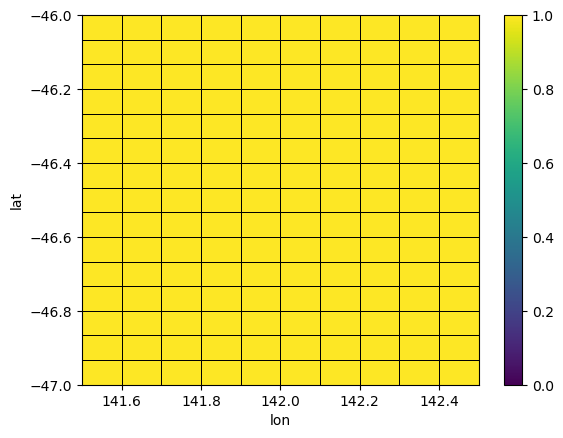

In [17]:
fig,ax=plt.subplots(1,1)
ESMF_ds.plot(ax=ax,vmax=1,vmin=0,edgecolors='black',linewidth=0.5)

In [6]:
# Note, we can also plot the mask by using the Mesh file connectivity lists. See https://gemini.google.com/share/aa910f049570
nodeCoords = ESMF_mesh.nodeCoords.data

# Find the min and max 
lon = nodeCoords[:,0]
lat = nodeCoords[:,1]

elementConn = ESMF_mesh.elementConn.values
elementMask = ESMF_mesh.elementMask.values

elementConn_0based = elementConn - 1

tri1 = elementConn_0based[:, [0, 1, 2]]
tri2 = elementConn_0based[:, [0, 2, 3]]

# Stack the new triangles
triangles = np.vstack([tri1, tri2])

# Duplicate the mask data for the new set of triangles
facecolors = np.hstack([elementMask, elementMask])


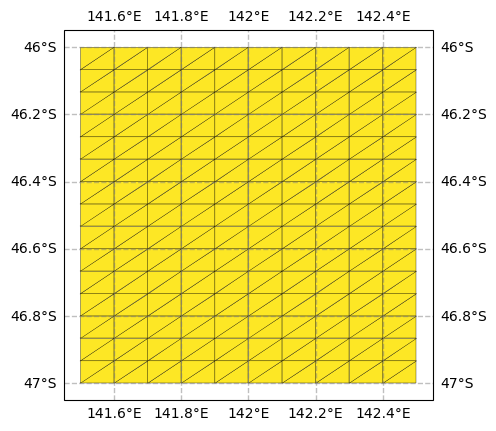

In [7]:
# Plot the mesh, navigated onto a lat/lon grid. These will render as triangles
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # Or another projection

plot = ax.tripcolor(
lon,                       # X-coordinates (Longitude) of the nodes
lat,                       # Y-coordinates (Latitude) of the nodes
triangles=triangles,       # Connectivity matrix for the triangles
facecolors=facecolors,     # Data defined at the element center (mask values)
cmap='viridis',            # Custom land/sea colormap
vmin=0, vmax=1,            # Set min/max for the colormap to ensure 0 and 1 are covered
edgecolors='k',         # 'k' or 'lightgray' to show grid lines
transform=ccrs.PlateCarree() # Specify the coordinate system of the input data
)

# Plot lat/lon axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(141.6, 142.4,0.2))  # e.g., every 30 degrees longitude
gl.ylocator = mticker.FixedLocator(np.arange(-47,-45.8,0.2))    # e.g., every 15 degrees latitude

In [8]:
# Let's load in the two UM grids defined with the bounds {'lat_min': -47.0, 'lat_max': -46.0, 'lon_min': 141.5, 'lon_max': 142.5}
# With resolution 0.04 degrees. The grids were computed with slightly different algorithms so they have slightly different co-ordinates.
# See https://github.com/21centuryweather/UM_configuration_tools/blob/main/scripts/regrid_regional_ocean_mesh.py

kieran_grid = xr.open_dataarray ( UM_DIR / 'dummy_kieran.nc' )
paul_grid = xr.open_dataarray ( UM_DIR / 'dummy_paul.nc' )

In [9]:
print(f'Kieran grid latitude values are {kieran_grid.lat.values[:6]}...')
print(f'Paul grid latitude values are {paul_grid.lat.values[:6]}...')

Kieran grid latitude values are [-46.98076923 -46.94230769 -46.90384615 -46.86538462 -46.82692308
 -46.78846154]...
Paul grid latitude values are [-47.   -46.96 -46.92 -46.88 -46.84 -46.8 ]...


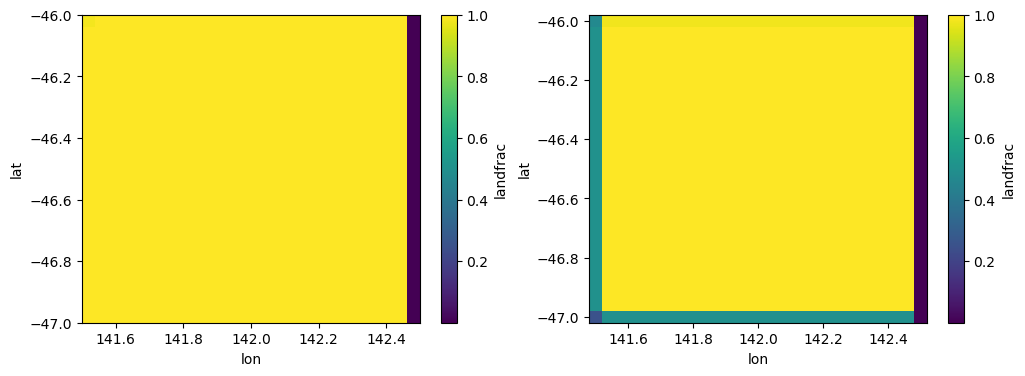

In [10]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
kieran_grid.plot(ax=ax[0])
paul_grid.plot(ax=ax[1])

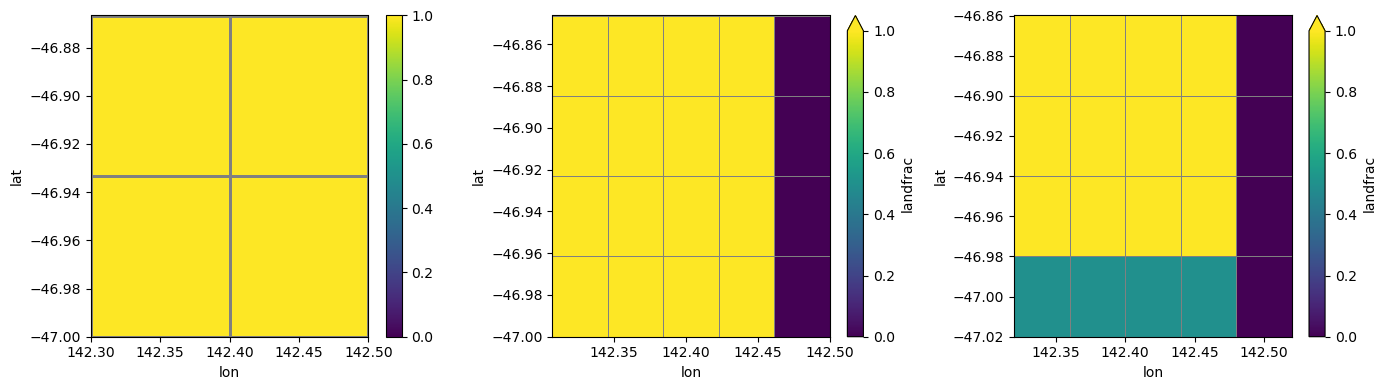

In [11]:
# Note - both UM grids have zero values of landfrac on the eastern edge of the domain. 
# Paul's grid has values <1 along the southern and western edge.
# Let's zoom into the south-eastern corner
fig,ax=plt.subplots(1,3,figsize=(14,4))
ESMF_ds.sel(lat=slice(-47,-46.85),lon=slice(142.3,142.5)).plot(ax=ax[0],vmax=1,vmin=0,edgecolors='grey')
kieran_grid.sel(lat=slice(-47,-46.85),lon=slice(142.3,142.5)).plot(ax=ax[1],vmax=1,vmin=0,edgecolors='grey',linewidth=0.5)
paul_grid.sel(lat=slice(-47,-46.85),lon=slice(142.3,142.5)).plot(ax=ax[2],vmax=1,vmin=0,edgecolors='grey',linewidth=0.5)
plt.tight_layout()

In [12]:
cons_grid = xr.open_dataarray ( UM_DIR / 'dummy_cons.nc' )

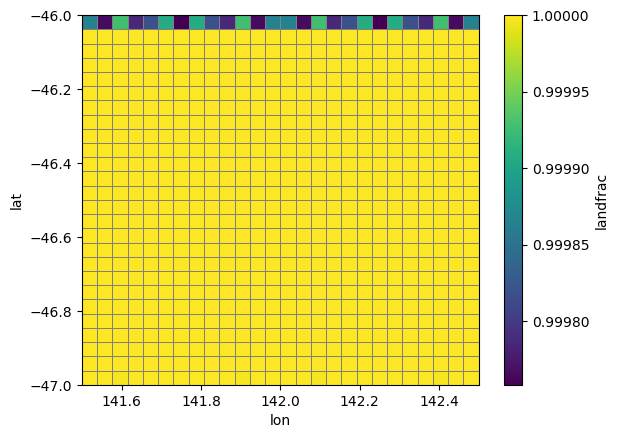

In [16]:
cons_grid.plot(edgecolors='grey',linewidth=0.

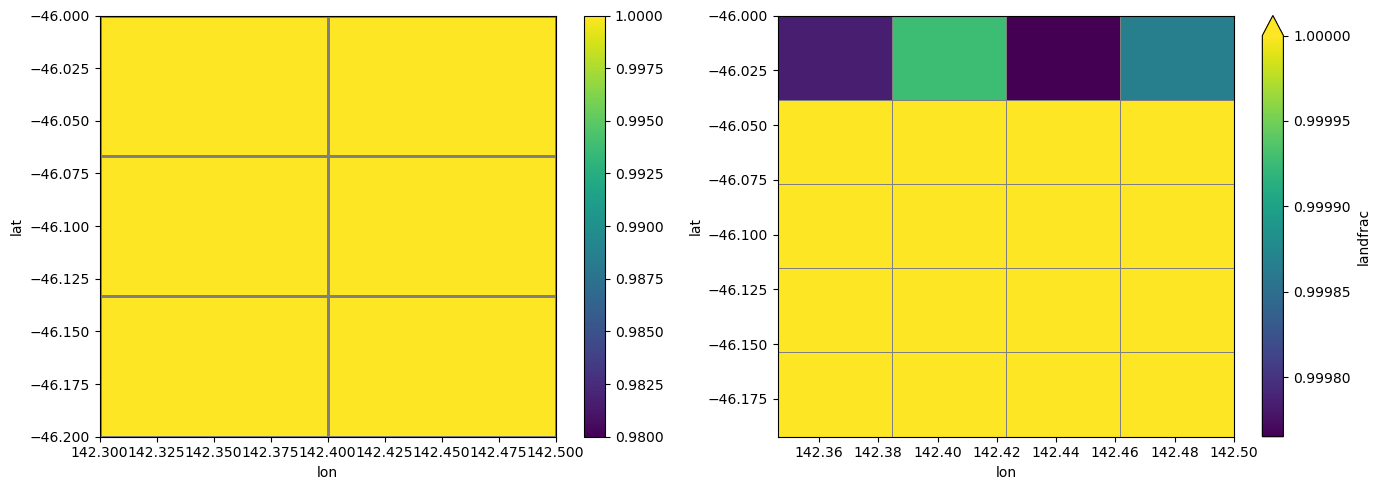

In [30]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
ESMF_ds.sel(lat=slice(-46.2,-46),lon=slice(142.35,142.5)).plot(ax=ax[0],vmax=1,vmin=0.98,edgecolors='grey')
cons_grid.sel(lat=slice(-46.2,-46),lon=slice(142.35,142.5)).plot(ax=ax[1],vmax=1,edgecolors='grey',linewidth=0.5)
plt.tight_layout()